# Optimizing Access Patterns

```{article-info}
:author: Altay Sansal
:date: "{sub-ref}`today`"
:read-time: "{sub-ref}`wordcount-minutes` min read"
:class-container: sd-p-0 sd-outline-muted sd-rounded-3 sd-font-weight-light
```

## Introduction

In this page we will be showing how we can take an existing MDIO and add
fast access, lossy, versions of the data in IL/XL/TWT cross-sections (slices).

We can re-use the MDIO dataset we created in the [Quickstart](#quickstart) page.
Please run it first.

Let's open the original MDIO first.

In [ ]:
from mdio import open_mdio

path = "filt_mig.mdio"

ds = open_mdio(path)
ds

<xarray.Dataset> Size: 403MB
Dimensions:           (inline: 345, crossline: 188, time: 1501)
Coordinates:
  * inline            (inline) int32 1kB 1 2 3 4 5 6 ... 340 341 342 343 344 345
  * crossline         (crossline) int32 752B 1 2 3 4 5 6 ... 184 185 186 187 188
  * time              (time) int32 6kB 0 2 4 6 8 10 ... 2992 2994 2996 2998 3000
    cdp_y             (inline, crossline) float64 519kB ...
    cdp_x             (inline, crossline) float64 519kB ...
Data variables:
    amplitude         (inline, crossline, time) float32 389MB ...
    headers           (inline, crossline) [('trace_seq_num_line', '<i4'), ('trace_seq_num_reel', '<i4'), ('orig_field_record_num', '<i4'), ('trace_num_orig_record', '<i4'), ('energy_source_point_num', '<i4'), ('ensemble_num', '<i4'), ('trace_num_ensemble', '<i4'), ('trace_id_code', '<i2'), ('vertically_summed_traces', '<i2'), ('horizontally_stacked_traces', '<i2'), ('data_use', '<i2'), ('source_to_receiver_distance', '<i4'), ('receiver_group_elevation', '<i4'), ('source_surface_elevation', '<i4'), ('source_depth_below_surface', '<i4'), ('receiver_datum_elevation', '<i4'), ('source_datum_elevation', '<i4'), ('source_water_depth', '<i4'), ('receiver_water_depth', '<i4'), ('elevation_depth_scalar', '<i2'), ('coordinate_scalar', '<i2'), ('source_coord_x', '<i4'), ('source_coord_y', '<i4'), ('group_coord_x', '<i4'), ('group_coord_y', '<i4'), ('coordinate_unit', '<i2'), ('weathering_velocity', '<i2'), ('subweathering_velocity', '<i2'), ('source_uphole_time', '<i2'), ('group_uphole_time', '<i2'), ('source_static_correction', '<i2'), ('receiver_static_correction', '<i2'), ('total_static_applied', '<i2'), ('lag_time_a', '<i2'), ('lag_time_b', '<i2'), ('delay_recording_time', '<i2'), ('mute_time_start', '<i2'), ('mute_time_end', '<i2'), ('samples_per_trace', '<i2'), ('sample_interval', '<i2'), ('instrument_gain_type', '<i2'), ('instrument_gain_const', '<i2'), ('instrument_gain_initial', '<i2'), ('correlated_data', '<i2'), ('sweep_freq_start', '<i2'), ('sweep_freq_end', '<i2'), ('sweep_length', '<i2'), ('sweep_type', '<i2'), ('sweep_taper_start', '<i2'), ('sweep_taper_end', '<i2'), ('taper_type', '<i2'), ('alias_filter_freq', '<i2'), ('alias_filter_slope', '<i2'), ('notch_filter_freq', '<i2'), ('notch_filter_slope', '<i2'), ('low_cut_freq', '<i2'), ('high_cut_freq', '<i2'), ('low_cut_slope', '<i2'), ('high_cut_slope', '<i2'), ('year_recorded', '<i2'), ('day_of_year', '<i2'), ('hour_of_day', '<i2'), ('minute_of_hour', '<i2'), ('second_of_minute', '<i2'), ('time_basis_code', '<i2'), ('trace_weighting_factor', '<i2'), ('group_num_roll_switch', '<i2'), ('group_num_first_trace', '<i2'), ('group_num_last_trace', '<i2'), ('gap_size', '<i2'), ('taper_overtravel', '<i2'), ('inline', '<i4'), ('crossline', '<i4'), ('cdp_x', '<i4'), ('cdp_y', '<i4')] 13MB ...
    segy_file_header  <U1 4B ...
    trace_mask        (inline, crossline) bool 65kB ...
Attributes:
    apiVersion:  1.1.1
    createdOn:   2025-12-19 16:05:58.230520+00:00
    name:        PostStack3DTime
    attributes:  {'surveyType': '3D', 'gatherType': 'stacked', 'defaultVariab...

## Optimizing IL/XL/TWT

In this cell, we will demonstrate how to create IL/XL and Z (two-way-time) optimized versions.

The API allows us to specify dimensions we want to generate fast access patterns for with desired
chunking.

The processing chunks is for efficiency. We want to make sure the processing chunks is at least
as large as the largest dimension in every processing chunk dimension. Once these are chunk
aligned, performance will be the highest.

By default the optimized access patterns use the ZFP Compressor. However it can be customized if needed.

The default compressor is set to `ZFPQuality.LOW`. Internally the algorithm dynamically adjusts the
ZFP tolerance based on global statistics (standard deviation) of the dataset. This yiels ~1:10 compression
out of the box.

In [ ]:
from mdio import OptimizedAccessPatternConfig

conf = OptimizedAccessPatternConfig(
    optimize_dimensions={
        "inline": (4, 512, 512),
        "crossline": (512, 4, 512),
        "time": (512, 512, 4),
    },
    processing_chunks={"inline": 512, "crossline": 512, "time": 512},
)

%time optimize_access_patterns(ds, conf, n_workers=4);

CPU times: user 287 ms, sys: 110 ms, total: 397 ms
Wall time: 3.14 s


We can now open the original MDIO dataset and the fast access patterns.

In [ ]:
ds = open_mdio(path)
ds

<xarray.Dataset> Size: 2GB
Dimensions:           (inline: 345, crossline: 188, time: 1501)
Coordinates:
  * inline            (inline) int32 1kB 1 2 3 4 5 6 ... 340 341 342 343 344 345
  * crossline         (crossline) int32 752B 1 2 3 4 5 6 ... 184 185 186 187 188
  * time              (time) int32 6kB 0 2 4 6 8 10 ... 2992 2994 2996 2998 3000
    cdp_x             (inline, crossline) float64 519kB ...
    cdp_y             (inline, crossline) float64 519kB ...
Data variables:
    segy_file_header  <U1 4B ...
    trace_mask        (inline, crossline) bool 65kB ...
    amplitude         (inline, crossline, time) float32 389MB ...
    headers           (inline, crossline) [('trace_seq_num_line', '<i4'), ('trace_seq_num_reel', '<i4'), ('orig_field_record_num', '<i4'), ('trace_num_orig_record', '<i4'), ('energy_source_point_num', '<i4'), ('ensemble_num', '<i4'), ('trace_num_ensemble', '<i4'), ('trace_id_code', '<i2'), ('vertically_summed_traces', '<i2'), ('horizontally_stacked_traces', '<i2'), ('data_use', '<i2'), ('source_to_receiver_distance', '<i4'), ('receiver_group_elevation', '<i4'), ('source_surface_elevation', '<i4'), ('source_depth_below_surface', '<i4'), ('receiver_datum_elevation', '<i4'), ('source_datum_elevation', '<i4'), ('source_water_depth', '<i4'), ('receiver_water_depth', '<i4'), ('elevation_depth_scalar', '<i2'), ('coordinate_scalar', '<i2'), ('source_coord_x', '<i4'), ('source_coord_y', '<i4'), ('group_coord_x', '<i4'), ('group_coord_y', '<i4'), ('coordinate_unit', '<i2'), ('weathering_velocity', '<i2'), ('subweathering_velocity', '<i2'), ('source_uphole_time', '<i2'), ('group_uphole_time', '<i2'), ('source_static_correction', '<i2'), ('receiver_static_correction', '<i2'), ('total_static_applied', '<i2'), ('lag_time_a', '<i2'), ('lag_time_b', '<i2'), ('delay_recording_time', '<i2'), ('mute_time_start', '<i2'), ('mute_time_end', '<i2'), ('samples_per_trace', '<i2'), ('sample_interval', '<i2'), ('instrument_gain_type', '<i2'), ('instrument_gain_const', '<i2'), ('instrument_gain_initial', '<i2'), ('correlated_data', '<i2'), ('sweep_freq_start', '<i2'), ('sweep_freq_end', '<i2'), ('sweep_length', '<i2'), ('sweep_type', '<i2'), ('sweep_taper_start', '<i2'), ('sweep_taper_end', '<i2'), ('taper_type', '<i2'), ('alias_filter_freq', '<i2'), ('alias_filter_slope', '<i2'), ('notch_filter_freq', '<i2'), ('notch_filter_slope', '<i2'), ('low_cut_freq', '<i2'), ('high_cut_freq', '<i2'), ('low_cut_slope', '<i2'), ('high_cut_slope', '<i2'), ('year_recorded', '<i2'), ('day_of_year', '<i2'), ('hour_of_day', '<i2'), ('minute_of_hour', '<i2'), ('second_of_minute', '<i2'), ('time_basis_code', '<i2'), ('trace_weighting_factor', '<i2'), ('group_num_roll_switch', '<i2'), ('group_num_first_trace', '<i2'), ('group_num_last_trace', '<i2'), ('gap_size', '<i2'), ('taper_overtravel', '<i2'), ('inline', '<i4'), ('crossline', '<i4'), ('cdp_x', '<i4'), ('cdp_y', '<i4')] 13MB ...
    fast_crossline    (inline, crossline, time) float32 389MB ...
    fast_inline       (inline, crossline, time) float32 389MB ...
    fast_time         (inline, crossline, time) float32 389MB ...
Attributes:
    apiVersion:  1.1.1
    createdOn:   2025-12-19 16:05:58.230520+00:00
    name:        PostStack3DTime
    attributes:  {'surveyType': '3D', 'gatherType': 'stacked', 'defaultVariab...

We can now compare the sizes of the compressed representations to original.

Below commands are for UNIX based operating systems and won't work on Windows.

In [ ]:
!du -hs {path}/amplitude
!du -hs {path}/fast_inline
!du -hs {path}/fast_crossline
!du -hs {path}/fast_time

149M	filt_mig.mdio/amplitude
 21M	filt_mig.mdio/fast_inline
 21M	filt_mig.mdio/fast_crossline
 21M	filt_mig.mdio/fast_time


Look at encoding of variable. We show data is rechunked with ZFP compression.

In [ ]:
print("Fast inline chunks\t", ds.fast_inline.encoding["chunks"], ds.fast_inline.encoding["serializer"])
print("Fast crossline chunks\t", ds.fast_crossline.encoding["chunks"], ds.fast_crossline.encoding["serializer"])
print("Fast time chunks\t", ds.fast_time.encoding["chunks"], ds.fast_time.encoding["serializer"])

Fast inline chunks	 (4, 512, 512) ZFPY(codec_name='numcodecs.zfpy', codec_config={'mode': 4, 'tolerance': 2.791618335971825, 'rate': None, 'precision': None})
Fast crossline chunks	 (512, 4, 512) ZFPY(codec_name='numcodecs.zfpy', codec_config={'mode': 4, 'tolerance': 2.791618335971825, 'rate': None, 'precision': None})
Fast time chunks	 (512, 512, 4) ZFPY(codec_name='numcodecs.zfpy', codec_config={'mode': 4, 'tolerance': 2.791618335971825, 'rate': None, 'precision': None})


Comparing local disk read speeds for inlines:

In [ ]:
%timeit ds.isel(inline=175).amplitude.compute()  # 3d chunked
%timeit ds.isel(inline=175).fast_inline.compute()  # inline optimized

34 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.08 ms ± 551 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For crosslines:

In [ ]:
%timeit ds.isel(crossline=90).amplitude.compute()  # 3d chunked
%timeit ds.isel(crossline=90).fast_crossline.compute()  # crossline optimized

46.5 ms ± 519 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.19 ms ± 135 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally, for Z (time-slices):

In [ ]:
%timeit ds.isel(time=751).amplitude.compute()  # 3d chunked
%timeit ds.isel(time=751).fast_time.compute()  # time-slice optimized

10.9 ms ± 210 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.47 ms ± 34.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can check the subjective quality of the compression by visually comparing
two inlines. Similar to the example we had in the [Compression](#compression) page.

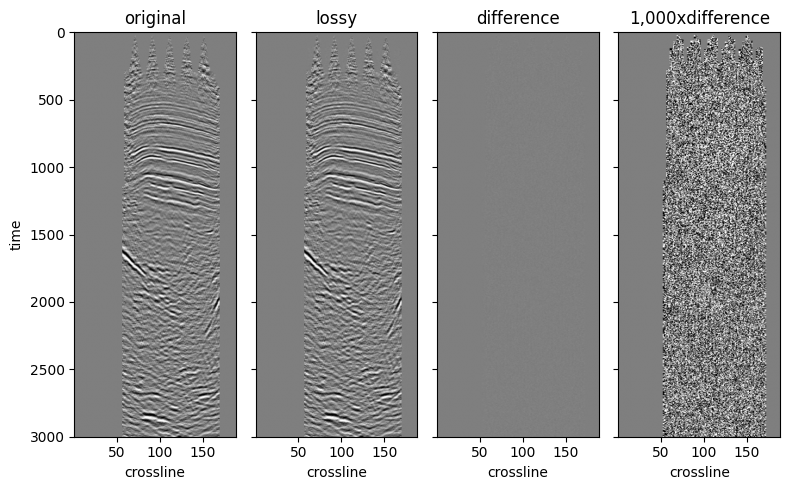

In [ ]:
import matplotlib.pyplot as plt

from mdio.builder.schemas.v1.stats import SummaryStatistics

stats = SummaryStatistics.model_validate_json(ds.amplitude.attrs["statsV1"])
imshow_kw = {
    "vmin": -3 * stats.std,
    "vmax": 3 * stats.std,
    "cmap": "gray_r",
    "interpolation": "bilinear",
    "yincrease": False,
    "add_colorbar": False,
}

fig, ax = plt.subplots(1, 4, sharex="all", sharey="all", figsize=(8, 5))

ds_inline = ds.sel(inline=200)

ds_inline.amplitude.T.plot.imshow(ax=ax[0], **imshow_kw)
ds_inline.fast_inline.T.plot.imshow(ax=ax[1], **imshow_kw)

diff = ds_inline.amplitude - ds_inline.fast_inline
diff.T.plot.imshow(ax=ax[2], **imshow_kw)
(1000 * diff).T.plot.imshow(ax=ax[3], **imshow_kw)

for axis, title in zip(ax.ravel(), ["original", "lossy", "difference", "1,000xdifference"], strict=False):
    if title != "original":
        axis.set_ylabel("")
    axis.set_title(title)

fig.tight_layout();

## Adjusting the Compressor

The compressor can be modified for fast access patterns but the default setting usually works quite well.
Given 1:10 compression ratio, the fidelity is quite high with the default `ZfpQuality.LOW` setting.

If you still want to use the ZFP compression but change the quality settings follow the instructions below.
We can also use `Blosc` compressor available in MDIO as well, but we will not demonstrate that here.

In [ ]:
from mdio.optimize import ZfpQuality
from mdio.optimize import get_default_zfp

get_default_zfp(stats, ZfpQuality.HIGH)

ZFP(name='zfp', mode=<ZFPMode.FIXED_ACCURACY: 'fixed_accuracy'>, tolerance=0.09305394453239418, rate=None, precision=None)

Here is a medium example. Note that the tolerance changes because it is based on dataset statistics and compression quality setting.

In [ ]:
get_default_zfp(stats, ZfpQuality.MEDIUM)

ZFP(name='zfp', mode=<ZFPMode.FIXED_ACCURACY: 'fixed_accuracy'>, tolerance=0.9305394453239417, rate=None, precision=None)

In conclusion, we show that by generating optimized, lossy compressed copies of the data
for certain access patterns yield big performance benefits when reading the data.

The differences are orders of magnitude larger on big datasets and remote stores, given available
network bandwidth.